In [125]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/code/functions/')
from gis_processing import *

In [3]:
data_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/wildfires-1001/data'

In [ ]:
county_grid = gpd.read_file(os.path.join(data_dir, 'clean_data/county_grid/county_grid.dbf'))

## Read in fire target data

In [4]:
target_df = {}
full_target_data = gpd.GeoDataFrame()
for i in np.arange(1, 4):
    target_df[i] = pd.read_pickle(os.path.join(data_dir, f'clean_data/target_full_{i}.pkl')) 
    full_target_data = full_target_data.append(target_df[i])

In [5]:
full_target_data['COUNTYFP'] = full_target_data['COUNTYFP'].astype(int)
full_target_data['GRID_ID'] = full_target_data['GRID_ID'].astype(int)
full_target_data['YEAR'] = full_target_data['date'].apply(lambda x:x.year)

## Read in demography data

In [6]:
ca_demogs = pd.read_csv(os.path.join(data_dir, 'clean_data/CA_demogs/demogs_arson_master.csv'))
ca_demogs.head()

,NAME,COUNTYFP,GRID_ID,YEAR,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM,AGEUNDER13_TOT,AGE1424_TOT,AGE2544_TOT,...,POPDENSITY,POPDENSITY_MALE,POPDENSITY_FEM,Structure Arsons,Mobile Arsons,Other Arsons,Total Arsons,Total Arsons Cleared,Unemployment,medianHHI2018
0,Plumas,63,49,2008,49.6,49.2,50.1,0.230043,0.211169,0.312208,...,1.732209,0.866061,0.866148,0,0,0,0,0,0.176,55079
1,Plumas,63,49,2009,49.6,49.2,50.1,0.230043,0.211169,0.312208,...,1.732209,0.866061,0.866148,1,1,0,2,0,0.176,55079
2,Plumas,63,49,2010,49.8,49.3,50.2,0.228572,0.209697,0.309784,...,1.724157,0.861039,0.863117,1,0,0,1,0,0.176,55079
3,Plumas,63,49,2011,50.3,49.6,50.9,0.227446,0.205022,0.303463,...,1.707273,0.855671,0.851602,2,0,5,7,6,0.176,55079
4,Plumas,63,49,2012,50.9,50.1,51.5,0.222684,0.194892,0.298701,...,1.677663,0.838615,0.839048,0,0,0,0,0,0.161,55079


In [7]:
##Merge demog onto full_target_data
print(full_target_data.shape)
full_target_data1 = pd.merge(full_target_data, ca_demogs, on = ['NAME', 'COUNTYFP', 'GRID_ID', 'YEAR'], how = 'left')
print(full_target_data1.shape)
full_target_data1.head()

(1443887, 23)
(1443887, 42)


,date,month_id,month_start,month_end,week_id,week_start,week_end,GRID_ID,FIRE_AREA,FIRE_KEY,...,POPDENSITY,POPDENSITY_MALE,POPDENSITY_FEM,Structure Arsons,Mobile Arsons,Other Arsons,Total Arsons,Total Arsons Cleared,Unemployment,medianHHI2018
0,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0,NaN,NaN,...,4.996877,2.778235,2.218641,9,1,1,11,2,0.133,48518
1,1990-01-02,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0,NaN,NaN,...,4.996877,2.778235,2.218641,9,1,1,11,2,0.133,48518
2,1990-01-03,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0,NaN,NaN,...,4.996877,2.778235,2.218641,9,1,1,11,2,0.133,48518
3,1990-01-04,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0,NaN,NaN,...,4.996877,2.778235,2.218641,9,1,1,11,2,0.133,48518
4,1990-01-05,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0,NaN,NaN,...,4.996877,2.778235,2.218641,9,1,1,11,2,0.133,48518


## Infrastructure Data

In [8]:
infrastructure = gpd.read_file(os.path.join(data_dir, 'clean_data/grid_infrastructure/grid_infrastructure_monthly.dbf'))
infrastructure.head()

,NAME,COUNTYFP,GEOID,ALAND,AWATER,COUNTY_ARE,GRID_AREA,GRID_ID,COUNTY_GRI,COUNTY_G_1,month_id,pl_count,total_pl_l,road_count,total_road,geometry
0,Del Norte,015,06015,2606100217,578760364,5.725577e+09,2.665977e+09,0.0,1.104368e+09,0.192883,1990_1,1.0,23134.077517,34,355922.196466,"POLYGON ((-13818818.380 5081091.901, -13818966..."
1,Del Norte,015,06015,2606100217,578760364,5.725577e+09,2.665977e+09,0.0,1.104368e+09,0.192883,1990_2,1.0,23134.077517,34,355922.196466,"POLYGON ((-13818818.380 5081091.901, -13818966..."
2,Del Norte,015,06015,2606100217,578760364,5.725577e+09,2.665977e+09,0.0,1.104368e+09,0.192883,1990_3,1.0,23134.077517,34,355922.196466,"POLYGON ((-13818818.380 5081091.901, -13818966..."
3,Del Norte,015,06015,2606100217,578760364,5.725577e+09,2.665977e+09,0.0,1.104368e+09,0.192883,1990_4,1.0,23134.077517,34,355922.196466,"POLYGON ((-13818818.380 5081091.901, -13818966..."
4,Del Norte,015,06015,2606100217,578760364,5.725577e+09,2.665977e+09,0.0,1.104368e+09,0.192883,1990_5,1.0,23134.077517,34,355922.196466,"POLYGON ((-13818818.380 5081091.901, -13818966..."


In [9]:
infrastructure['COUNTYFP'] = infrastructure['COUNTYFP'].astype(float).astype(int)
infrastructure['GRID_ID'] = infrastructure['GRID_ID'].astype(int)

In [10]:
infrastructure_sub = infrastructure[['GRID_ID', 'month_id', 'pl_count', 'total_pl_l', 'road_count', 'total_road']]

In [11]:
full_target_data2 = full_target_data1.merge(infrastructure_sub, on = ['GRID_ID', 'month_id'], how = 'left')

print(full_target_data2.shape)
full_target_data2.head()

(1443887, 46)


,date,month_id,month_start,month_end,week_id,week_start,week_end,GRID_ID,FIRE_AREA,FIRE_KEY,...,Mobile Arsons,Other Arsons,Total Arsons,Total Arsons Cleared,Unemployment,medianHHI2018,pl_count,total_pl_l,road_count,total_road
0,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0,NaN,NaN,...,1,1,11,2,0.133,48518,1.0,23134.077517,34.0,355922.196466
1,1990-01-02,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0,NaN,NaN,...,1,1,11,2,0.133,48518,1.0,23134.077517,34.0,355922.196466
2,1990-01-03,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0,NaN,NaN,...,1,1,11,2,0.133,48518,1.0,23134.077517,34.0,355922.196466
3,1990-01-04,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0,NaN,NaN,...,1,1,11,2,0.133,48518,1.0,23134.077517,34.0,355922.196466
4,1990-01-05,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0,NaN,NaN,...,1,1,11,2,0.133,48518,1.0,23134.077517,34.0,355922.196466


In [446]:
full_target_data2['FIRE_ACRES'] = full_target_data2['FIRE_AREA']* 0.0002471054
full_target_data2['FIRE_ACRES'] = full_target_data2['FIRE_ACRES'].fillna(0)

In [455]:
fire_acres = full_target_data2[full_target_data2['FIRE_ACRES']!=0]
fire_acres['FIRE_ACRES'].describe()

count     74445.000000
mean      12663.841653
std       40748.433972
min           0.001357
25%          62.979526
50%         552.472735
75%        5570.187226
max      410202.494043
Name: FIRE_ACRES, dtype: float64

In [ ]:
## Uses NWCG fire size class code https://www.nwcg.gov/sites/default/files/data-standards/pdf/values.pdf
target_full['fire_class_size'] = np.where(target_full['FIRE_ACRES']<100, 1,
                                          np.where((target_full['FIRE_AREA']>=10000) & \
                                                   (target_full['FIRE_AREA']<100000), 2,
                                                   np.where((target_full['FIRE_AREA']>=100000) & \
                                                            (target_full['FIRE_AREA']< 500000) , 3,
                                                            np.where((target_full['FIRE_AREA']>=500000) & \
                                                            (target_full['FIRE_AREA']< 1000000) , 4, 
                                                                     np.where(target_full['FIRE_AREA']>=1000000, 5, 0)))))

In [334]:
week_target_data = full_target_data2.drop(['date', 'month_id', 'month_start', 'month_end', 'week_start', 'week_end',
                                           'GRID_ID', 'FIRE_AREA', 'FIRE_KEY', 'start_date', 'end_date',
                                          'geometry', 'FIRE_GRID_INT_AREA', 'Y_bin', 'Y_fire_count', 'NAME', 'COUNTYFP',
                                           'COUNTY_AREA_x', 'GRID_AREA','Y_fire_area_prop'], axis = 1)
week_target_data = week_target_data.drop_duplicates()
week_target_data.shape

(210577, 26)

In [335]:
week_target_data['fire_class_size'] = week_target_data['fire_class_size'].fillna(0)
week_target_data.head()

,week_id,YEAR,fire_class_size,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM,AGEUNDER13_TOT,AGE1424_TOT,AGE2544_TOT,AGE4564_TOT,...,Mobile Arsons,Other Arsons,Total Arsons,Total Arsons Cleared,Unemployment,medianHHI2018,pl_count,total_pl_l,road_count,total_road
0,1990_1,1990,0,39.1,37.3,42.2,0.813892,0.698096,1.382044,1.426407,...,1,1,11,2,0.133,48518,1.0,23134.077517,34.0,355922.196466
7,1990_2,1990,0,39.1,37.3,42.2,0.813892,0.698096,1.382044,1.426407,...,1,1,11,2,0.133,48518,1.0,23134.077517,34.0,355922.196466
14,1990_3,1990,0,39.1,37.3,42.2,0.813892,0.698096,1.382044,1.426407,...,1,1,11,2,0.133,48518,1.0,23134.077517,34.0,355922.196466
21,1990_4,1990,0,39.1,37.3,42.2,0.813892,0.698096,1.382044,1.426407,...,1,1,11,2,0.133,48518,1.0,23134.077517,34.0,355922.196466
28,1990_5,1990,0,39.1,37.3,42.2,0.813892,0.698096,1.382044,1.426407,...,1,1,11,2,0.133,48518,1.0,23134.077517,34.0,355922.196466


In [313]:
X_train = week_target_data[week_target_data['YEAR']<=2017].drop(['YEAR', 'week_id', 'Y_fire_area_prop'], axis = 1)
Y_train = week_target_data[week_target_data['YEAR']<=2017]['Y_fire_area_prop']

In [321]:
X_test = week_target_data[week_target_data['YEAR']==2018].drop(['YEAR', 'week_id', 'Y_fire_area_prop'], axis = 1)
Y_test = week_target_data[week_target_data['YEAR']==2018]['Y_fire_area_prop']

In [342]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [316]:
rf = RandomForestRegressor()
rf_fit = rf.fit(X_train, Y_train)

In [320]:
Y_preds = rf_fit.predict(X_test)

In [327]:
rf_fit.score(X_test, Y_test)

0.11544244630468214

In [329]:
rf.feature_importances_

array([0.17443565, 0.01609222, 0.02215852, 0.02026797, 0.0255211 ,
       0.02033567, 0.02326657, 0.01897689, 0.02002376, 0.00752651,
       0.01575745, 0.01468814, 0.02003825, 0.05720163, 0.05163866,
       0.0783811 , 0.05303741, 0.05527962, 0.06844138, 0.01367242,
       0.06857929, 0.06662874, 0.0560732 , 0.03197784])

In [365]:
targets = week_target_data[(week_target_data['YEAR']<=2017) & (week_target_data['fire_class_size']!=0)]
non_targets = week_target_data[(week_target_data['YEAR']<=2017) & (week_target_data['fire_class_size']==0)]
non_targets_samp = non_targets.sample(frac = 0.3)
new_train = non_targets_samp.append(targets)
print(len(targets)/len(non_targets_samp))

0.21404980340760157


In [378]:
x = week_target_data.drop('week_id', axis = 1)
x = x.drop_duplicates()

In [440]:
X_train1 = x[x['YEAR'] <= 2017].drop(['YEAR', 'fire_class_size'], axis = 1)
Y_train1 = x[x['YEAR'] <= 2017]['fire_class_size']
X_test1 = x[x['YEAR']==2018].drop(['YEAR', 'fire_class_size'], axis = 1)
Y_test1 = x[x['YEAR']==2018]['fire_class_size']

In [385]:
print(Y_train1.value_counts())

0    3792
5    1062
3     883
2     848
4     428
1     174
Name: fire_class_size, dtype: int64


In [386]:
rf_clf = RandomForestClassifier()
rf_clf_fit = rf_clf.fit(X_train1, Y_train1)

In [439]:
Y_preds1 = rf_clf_fit.predict(X_test1)
print(np.unique(Y_preds1))

[0 2 3 4 5]


In [388]:
np.unique(Y_preds1, return_counts =True)

(array([0, 2, 3, 4, 5]), array([303,  22,  13,   2,   4]))

In [413]:
Y_test1.name

'fire_class_size'

In [430]:
#y_test_array = Y_test1['fire_class_size']
comp_test1 = Y_test1.copy()
comp_test1 = pd.concat([comp_test1, pd.Series(Y_preds1)], axis = 1, ignore_index = True)

In [442]:
match = 0
for i in range(len(Y_test1)):
    #print(Y_preds1[i])
    #print(Y_test1.iloc[i])
    if Y_preds1[i].astype(int) == Y_test1.iloc[i]:
        match+=1

0
0
0
2
0
0
0
1
0
2
0
0
0
3
0
2
0
0
3
0
3
3
3
2
3
5
3
1
3
0
3
3
3
5
0
0
0
2
0
5
0
3
0
0
0
1
0
2
0
5
0
0
0
1
0
4
0
0
0
0
0
3
0
0
0
4
0
1
0
0
0
3
0
2
0
1
0
0
0
2
0
0
0
0
0
5
0
4
0
3
0
2
0
0
0
4
0
2
0
3
0
5
0
0
0
2
2
0
2
2
4
0
4
5
0
0
0
2
0
3
0
0
0
5
0
2
0
0
0
2
0
0
0
3
0
2
0
5
0
1
0
5
0
0
0
3
0
4
0
5
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
1
0
5
2
0
2
2
2
1
2
5
2
4
2
3
3
0
3
4
0
0
0
1
0
2
0
5
0
0
0
3
0
1
0
5
0
3
0
0
0
5
0
1
0
2
0
0
0
4
0
0
0
5
0
0
0
0
0
1
0
5
0
5
0
1
0
0
0
2
0
3
0
4
0
0
0
3
0
2
0
1
0
0
0
1
0
2
0
3
0
5
0
4
0
0
0
5
0
3
0
0
0
5
0
2
0
0
0
2
0
3
0
1
0
0
0
5
0
2
0
3
0
0
0
2
0
5
0
0
0
5
0
0
0
5
0
2
0
0
0
0
0
2
0
3
0
1
0
0
0
2
0
5
0
4
0
0
0
5
0
3
0
0
0
5
0
0
0
5
0
3
0
0
0
3
0
5
0
2
0
0
0
5
0
0
0
1
0
2
0
3
0
0
0
1
0
0
0
2
0
0
0
2
0
5
0
3
0
0
0
3
0
5
0
0
0
5
0
0
0
4
0
5
0
0
0
4
0
5
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
4
0
5
0
0
0
4
0
5
0
3
0
0
0
0
0
0
0
2
0
0
0
2
0
5
0
4
0
3
0
0
0
5
0
0
0
2
0
0
0
2
0
0
0
5
0
4
0
3
0
0
0
5
0
0
0
0
0
2
0
3
0
5
2
0
2
2
2
3
2
5
2
0
2
2
2
3
2
4
0
0
0
5
0
0
0
3
0
0
0
5


In [443]:
match/len(Y_test1)

0.37790697674418605

## NOAA Data

In [12]:
noaa = pd.read_csv(os.path.join(data_dir, 'clean_data/NOAA/noaa_grid_data.csv'))
print(noaa.shape)
noaa.head()

(1431487, 11)


,GRID_ID,ID,distance,YEAR,MONTH,DAY,PRCP,SNOW,TMAX,TMIN,TOBS
0,0.0,USW00024286,0.419345,2000,9,1,0.0,NaN,161.0,111.0,NaN
1,0.0,USW00024286,0.419345,2000,9,10,0.0,NaN,183.0,94.0,NaN
2,0.0,USW00024286,0.419345,2000,9,11,3.0,NaN,161.0,117.0,NaN
3,0.0,USW00024286,0.419345,2000,9,12,0.0,NaN,167.0,111.0,NaN
4,0.0,USW00024286,0.419345,2000,9,13,0.0,NaN,228.0,122.0,NaN


In [43]:
noaa_cols = ['PRCP', 'SNOW', 'TMAX', 'TMIN', 'TOBS']

In [13]:
for ID in noaa['ID'].unique():
    if len(noaa[(noaa['ID']==ID) & (noaa['TMAX'].isna()==False) & (noaa['TMIN'].isna()==False)])==0:
        print(ID)
        print(noaa[noaa['ID']==ID]['GRID_ID'].unique())

USC00046194
[38.]
USC00045151
[89.]
USC00046602
[112.]


#### Create date variable for NOAA Data

In [176]:
#drop rows where all NOAA data is na
print(noaa.shape)
noaa_non_nans = noaa.dropna(subset = noaa_cols, axis = 0, how = 'all')
print(noaa_non_nans.shape)
print(len(noaa_non_nans['GRID_ID'].unique()))
noaa_non_nans['date'] = noaa_non_nans[['YEAR', 'MONTH', 'DAY']].apply(lambda x: dt(year = x[0], month = x[1], day = x[2]), axis = 1)

(1431487, 11)
(1380700, 11)
134


<ipython-input-176-d9c0e9675a8d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noaa_non_nans['date'] = noaa_non_nans[['YEAR', 'MONTH', 'DAY']].apply(lambda x: dt(year = x[0], month = x[1], day = x[2]), axis = 1)


In [177]:
noaa_non_nans['WEEK'] = noaa_non_nans['date'].apply(lambda x:x.week)
noaa_non_nans['week_id'] = np.where((noaa_non_nans['MONTH'] ==12) & (noaa_non_nans['WEEK'] ==1),
                                        noaa_non_nans['YEAR'].apply(lambda x: str(x+1))+"_"+ noaa_non_nans['WEEK'].astype(str), 
                                       noaa_non_nans['YEAR'].astype(str) + '_' + noaa_non_nans['WEEK'].astype(str))

<ipython-input-177-103c16280ecc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noaa_non_nans['WEEK'] = noaa_non_nans['date'].apply(lambda x:x.week)
<ipython-input-177-103c16280ecc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noaa_non_nans['week_id'] = np.where((noaa_non_nans['MONTH'] ==12) & (noaa_non_nans['WEEK'] ==1),


In [195]:
noaa_non_nans['month_id'] = noaa_non_nans['YEAR'].astype(str) + "_" + noaa_non_nans['MONTH'].astype(str)
noaa_non_nans.head()

<ipython-input-195-b85b894c98b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noaa_non_nans['month_id'] = noaa_non_nans['YEAR'].astype(str) + "_" + noaa_non_nans['MONTH'].astype(str)


,GRID_ID,ID,distance,YEAR,MONTH,DAY,PRCP,SNOW,TMAX,TMIN,TOBS,date,WEEK,week_id,month_id
0,0.0,USW00024286,0.419345,2000,9,1,0.0,NaN,161.0,111.0,NaN,2000-09-01,35,2000_35,2000_9
1,0.0,USW00024286,0.419345,2000,9,10,0.0,NaN,183.0,94.0,NaN,2000-09-10,36,2000_36,2000_9
2,0.0,USW00024286,0.419345,2000,9,11,3.0,NaN,161.0,117.0,NaN,2000-09-11,37,2000_37,2000_9
3,0.0,USW00024286,0.419345,2000,9,12,0.0,NaN,167.0,111.0,NaN,2000-09-12,37,2000_37,2000_9
4,0.0,USW00024286,0.419345,2000,9,13,0.0,NaN,228.0,122.0,NaN,2000-09-13,37,2000_37,2000_9


#### Counting nulls

In [100]:
#Figuring out if we can average on weeks and get populated values for all grid_ids
noaa_ind_cols= []
for col in noaa_cols:
    noaa_non_nans[col+'_ind'] = np.where(noaa_non_nans[col].isna()==False, 1, 0)
    noaa_ind_cols.append(col+'_ind')
noaa_agg_nans = noaa_non_nans[['GRID_ID']+noaa_ind_cols].groupby(['GRID_ID']).sum().reset_index()

<ipython-input-100-0286c0d54b04>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noaa_non_nans[col+'_ind'] = np.where(noaa_non_nans[col].isna()==False, 1, 0)
<ipython-input-100-0286c0d54b04>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noaa_non_nans[col+'_ind'] = np.where(noaa_non_nans[col].isna()==False, 1, 0)
<ipython-input-100-0286c0d54b04>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

(array([40.,  0.,  6.,  2.,  4.,  1., 40., 10.,  7., 24.]),
 array([    0. ,  1127.1,  2254.2,  3381.3,  4508.4,  5635.5,  6762.6,
         7889.7,  9016.8, 10143.9, 11271. ]),
 <BarContainer object of 10 artists>)

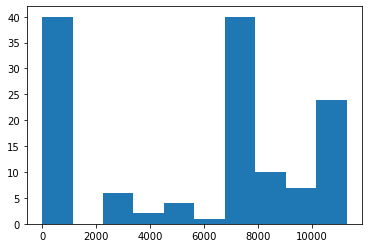

In [88]:
plt.hist(noaa_agg_nans['SNOW_ind'])

In [162]:
##Identifying if snow is missing from specific grid IDs or at random
GID_no_snow = noaa_agg_nans[noaa_agg_nans['SNOW_ind']==0]['GRID_ID'].astype(int).unique()
GID_snow = noaa_agg_nans[noaa_agg_nans['SNOW_ind']>0]['GRID_ID'].astype(int).unique()
sub_grid_no_snow = county_grid[county_grid['GRID_ID'].isin(GID_no_snow)]
sub_grid_snow = county_grid[county_grid['GRID_ID'].isin(GID_snow)]

#### Plotting snow v. no snow grid sections

<AxesSubplot:>

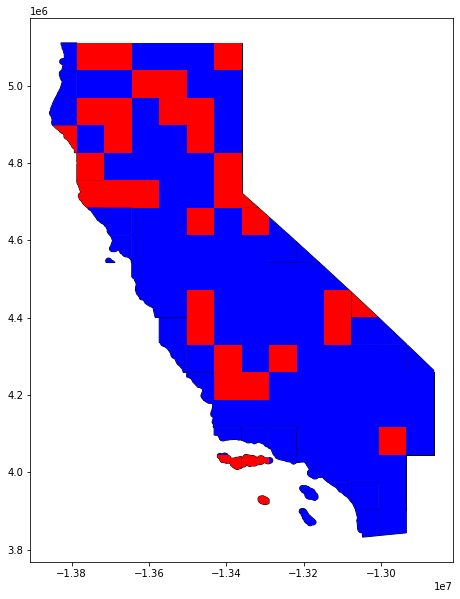

In [91]:
##Plotting snow v. no snow
ax = county_grid.plot(color = 'white', edgecolor = 'black', figsize = (10,10))
sub_grid_no_snow.plot(ax=ax, color = 'red', figsize = (10,10))
sub_grid_snow.plot(ax=ax, color = 'blue', figsize = (10,10))

#### Plotting snow v. no snow grid sections

In [163]:
##Identifying if PRCP is missing from specific grid IDs or at random
GID_no_prcp = noaa_agg_nans[noaa_agg_nans['PRCP_ind']==0]['GRID_ID'].astype(int).unique()
GID_prcp = noaa_agg_nans[noaa_agg_nans['PRCP_ind']!=0]['GRID_ID'].astype(int).unique()
sub_grid_no_prcp = county_grid[county_grid['GRID_ID'].isin(GID_no_prcp)]
sub_grid_prcp = county_grid[county_grid['GRID_ID'].isin(GID_prcp)]

<AxesSubplot:>

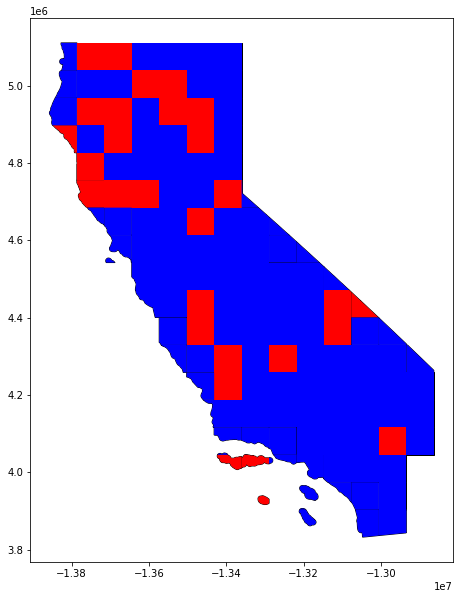

In [94]:
##Plotting prcp v. no prcp
ax = county_grid.plot(color = 'white', edgecolor = 'black', figsize = (10,10))
sub_grid_no_prcp.plot(ax=ax, color = 'red', figsize = (10,10))
sub_grid_prcp.plot(ax=ax, color = 'blue', figsize = (10,10))

### Aggregating to the week level 

In [188]:
noaa_week_agg = noaa_non_nans[['GRID_ID', 'week_id']+noaa_cols].groupby(['GRID_ID', 'week_id']).mean().reset_index()
noaa_week_agg.head()

,GRID_ID,week_id,PRCP,SNOW,TMAX,TMIN,TOBS
0,0.0,2000_35,35.666667,NaN,168.333333,111.000000,NaN
1,0.0,2000_36,0.428571,NaN,165.714286,84.714286,NaN
2,0.0,2000_37,6.285714,NaN,186.571429,118.142857,NaN
3,0.0,2000_38,0.500000,NaN,195.500000,100.833333,NaN
4,0.0,2000_39,1.500000,NaN,165.833333,92.666667,NaN


#### Imputing missing values by finding closest grid and taking NOAA data from that 

In [106]:
county_grid['GRID_ID']  = county_grid['GRID_ID'].astype(int)
county_grid['GRID_CENTROID'] = county_grid.geometry.centroid
county_grid.head()

,NAME,COUNTYFP,GEOID,ALAND,AWATER,COUNTY_ARE,GRID_AREA,GRID_ID,COUNTY_GRI,COUNTY_G_1,geometry,GRID_CENTROID
0,Plumas,063,06063,6612400993,156387635,1.155000e+10,5.041000e+09,49,4.936293e+09,0.427385,"POLYGON ((-13502275.000 4897930.000, -13431275...",POINT (-13466775.000 4862430.000)
1,Sierra,091,06091,2468694587,23299110,4.200450e+09,5.041000e+09,50,1.535563e+09,0.365571,"POLYGON ((-13502275.000 4826930.000, -13431275...",POINT (-13466775.000 4791430.000)
2,Sierra,091,06091,2468694587,23299110,4.200450e+09,5.041000e+09,65,2.544187e+09,0.605694,"POLYGON ((-13431275.000 4826930.000, -13360275...",POINT (-13395775.000 4791430.000)
3,Sacramento,067,06067,2499183617,76073827,4.205267e+09,5.041000e+09,39,2.029400e+09,0.482585,"POLYGON ((-13573275.000 4684930.000, -13502275...",POINT (-13537775.000 4649430.000)
4,Contra Costa,013,06013,1871930816,209819213,3.351027e+09,5.041000e+09,40,1.618024e+09,0.482844,"POLYGON ((-13573275.000 4613930.000, -13502275...",POINT (-13537775.000 4578430.000)


In [168]:
county_grid_centroid = gpd.GeoDataFrame(county_grid[['GRID_ID']], geometry = county_grid.geometry.centroid, \
                            crs={'init' :'epsg:4326'})
county_grid_centroid = county_grid_centroid.to_crs('epsg:4326')
county_grid_centroid.head()

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-168-ec29cd4d2943>:1: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  county_grid_centroid = gpd.GeoDataFrame(county_grid[['GRID_ID']], geometry = county_grid.geometry.centroid, \


,GRID_ID,geometry
0,49,POINT (-120.97410 39.97583)
1,50,POINT (-120.97410 39.48532)
2,65,POINT (-120.33629 39.48532)
3,39,POINT (-121.61190 38.49387)
4,40,POINT (-121.61190 37.99295)


In [172]:
nearest_grid_w_snow = {}

for g1 in GID_no_snow:
    min_dist = 100
    nearest_grid_w_snow[g1] = 0
    g1_centroid = county_grid_centroid[county_grid_centroid['GRID_ID']==g1].geometry
    g1_point = Point(g1_centroid.x, g1_centroid.y)
    for g2 in GID_snow:
        g2_centroid = county_grid_centroid[county_grid_centroid['GRID_ID']==g2].geometry
        g2_point = Point(g2_centroid.x, g2_centroid.y)
        dist = g1_point.distance(g2_point)
        if dist <= min_dist:
            min_dist = dist
            nearest_grid_w_snow[g1] = g2
        else:
            continue

In [214]:
nearest_grid_w_prcp = {}

for g1 in GID_no_prcp:
    min_dist = 100
    nearest_grid_w_prcp[g1] = 0
    g1_centroid = county_grid_centroid[county_grid_centroid['GRID_ID']==g1].geometry
    g1_point = Point(g1_centroid.x, g1_centroid.y)
    for g2 in GID_prcp:
        g2_centroid = county_grid_centroid[county_grid_centroid['GRID_ID']!=g2]
        g2_centroid['dist'] = g2_centroid['geometry'].apply(lambda z: g1_point.distance(z)) 
        #print(g2_point)
        dist = g1_point.distance(g2_centroid.geometry[0])
        #print(dist)
        if dist <= min_dist:
            min_dist = dist
            nearest_grid_w_prcp[g1] = g2
        else:
            continue

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

In [215]:
g2_centroid

,GRID_ID,geometry,dist
0,49,POINT (-120.97410 39.97583),7.150021
1,50,POINT (-120.97410 39.48532),6.773821
2,65,POINT (-120.33629 39.48532),6.371525
3,39,POINT (-121.61190 38.49387),6.547371
4,40,POINT (-121.61190 37.99295),6.245687
...,...,...,...
129,98,POINT (-119.06069 36.46959),3.290758
130,25,POINT (-122.24971 39.97583),8.008757
131,36,POINT (-121.61190 39.97583),7.564701
132,54,POINT (-120.97410 37.48859),5.433942


### Try Month Level

In [196]:
noaa_month_agg = noaa_non_nans[['GRID_ID', 'month_id']+noaa_cols].groupby(['GRID_ID', 'month_id']).mean().reset_index()
noaa_month_agg.head()

,GRID_ID,month_id,PRCP,SNOW,TMAX,TMIN,TOBS
0,0.0,2000_10,51.633333,NaN,148.866667,79.066667,NaN
1,0.0,2000_11,29.433333,NaN,122.300000,53.166667,NaN
2,0.0,2000_12,33.322581,NaN,135.870968,56.290323,NaN
3,0.0,2000_9,5.724138,NaN,177.206897,100.482759,NaN
4,0.0,2001_1,30.483871,NaN,126.193548,38.419355,NaN


In [252]:
print(county_grid_centroid[county_grid_centroid['GRID_ID'].isin([129, 139])])

     GRID_ID                     geometry
102      129  POINT (-117.14727 34.91569)
107      139  POINT (-116.50947 34.39103)


In [288]:
def impute_missing_values(df, col, centroid_grid):
    df_missing = df[df[col].isna()]
    df_impute = pd.DataFrame()
    print(df_missing.shape)
    for g in df_missing['GRID_ID'].unique():
        g_df_miss = df_missing[df_missing['GRID_ID']==g]
        miss_weeks = g_df_miss['week_id'].unique().tolist()
        miss_df
        pop_oth_grid = df[(df['week_id'].isin(miss_weeks)) & (df[col].isna()== False)]['GRID_ID'].unique()
        if g == 44:
            print(df[(df['week_id'].isin(miss_weeks)) & (df['GRID_ID']== 43)])
        #Find grid section that is closest
        g_centroid = centroid_grid[centroid_grid['GRID_ID']==g].geometry
        g_point = Point(g_centroid.x, g_centroid.y)
       
        g2_centroid = centroid_grid[centroid_grid['GRID_ID'].isin(pop_oth_grid)]
        g2_centroid['dist'] = g2_centroid['geometry'].apply(lambda z: g_point.distance(z)) 
        imp_grid_id = g2_centroid[g2_centroid['dist']==g2_centroid['dist'].min()]['GRID_ID'].iloc[0]
        imp_df = df[df['GRID_ID']==imp_grid_id][['week_id', col]].rename(columns = {col: f'{col}_imp'})
        if g == 44:
            print(imp_grid_id)
        g_df_miss_app = pd.merge(g_df_miss, imp_df, on = 'week_id')
        if len(g_df_miss_app)!= len(g_df_miss):
            if g == 44:
                print(g_df_miss_app.head())
                print(g_df_miss.head(10))
        df_impute = df_impute.append(g_df_miss_app)
    print(df_impute.shape)
    return df_impute
        

In [289]:
tmin_impute = impute_missing_values(noaa_week_agg, 'TMIN', county_grid_centroid)

(11171, 7)


/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

       GRID_ID  week_id  PRCP  SNOW   TMAX        TMIN        TOBS
60459     43.0  2016_30   0.0   NaN  238.0  110.428571  211.142857
43
   GRID_ID  week_id  PRCP  SNOW   TMAX  TMIN   TOBS    TMIN_imp
0     44.0  2016_30   0.0   NaN  267.0   NaN  200.0  110.428571
       GRID_ID  week_id       PRCP  SNOW  TMAX  TMIN  TOBS
60690     44.0   1990_1  25.714286   0.0   NaN   NaN   NaN
60691     44.0  1990_10  38.857143   0.0   NaN   NaN   NaN
60692     44.0  1990_11   8.428571   0.0   NaN   NaN   NaN
60693     44.0  1990_12   0.000000   0.0   NaN   NaN   NaN
60694     44.0  1990_13   0.000000   0.0   NaN   NaN   NaN
60695     44.0  1990_14   0.000000   0.0   NaN   NaN   NaN
60696     44.0  1990_15   0.000000   0.0   NaN   NaN   NaN
60697     44.0  1990_16   1.857143   0.0   NaN   NaN   NaN
60698     44.0  1990_17  36.571429   0.0   NaN   NaN   NaN
60699     44.0  1990_18   0.000000   0.0   NaN   NaN   NaN


/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

(10292, 8)


/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCop

In [266]:
tmin_impute.head()

,GRID_ID,week_id,PRCP,SNOW,TMAX,TMIN,TOBS,TMIN_imp
0,7.0,1993_53,NaN,0.0,NaN,NaN,NaN,-7.333333
1,7.0,1995_52,30.0,0.0,NaN,NaN,NaN,38.571429
2,7.0,1999_53,0.0,0.0,NaN,NaN,NaN,2.000000
3,7.0,2004_32,0.0,0.0,NaN,NaN,NaN,129.428571
4,7.0,2005_53,NaN,0.0,NaN,NaN,NaN,0.000000


### Imputation

In [193]:
print(noaa_week_agg[noaa_week_agg['TMAX'].isna()]['GRID_ID'].unique())

[  7.   9.  12.  14.  17.  19.  22.  26.  28.  29.  30.  33.  36.  37.
  38.  39.  40.  42.  44.  46.  47.  50.  51.  54.  58.  62.  63.  64.
  65.  67.  68.  69.  70.  71.  74.  75.  83.  84.  85.  88.  89.  90.
  91.  94.  95.  96.  97. 101. 102. 103. 108. 109. 110. 111. 112. 114.
 115. 119. 121. 122. 123. 124. 127. 128. 129. 130. 132. 133. 137. 138.
 140. 141. 145. 146. 147.]


<AxesSubplot:>

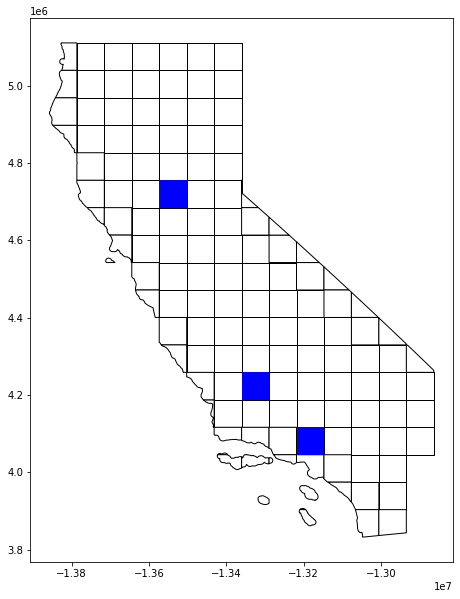

In [18]:
#Plot this fire data onto the grid
ax = county_grid.plot(color = 'white', edgecolor = 'black', figsize = (10,10))
sub_grid.plot(ax=ax, color = 'blue', figsize = (10,10))